# test_interp_z

This notebook contains testing for interpolating from w-grid to rho-grid. The other way around implies extrapolation andis not addressed here, because it is believed by the author that wrapping a c-coded interpolation routine with apply-ufunc is more efficient in this case

In [110]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr
import crocosi.postp as pp
from crocosi.gridop import get_z, N2Profile
import crocosi.gridop as gp
#from crocosi.vmodes import get_vmodes

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8788')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:57838 Dashboard: http://127.0.0.1:8788/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
root_path = '/home/datawork-lops-osi/aponte/bturb_itide/jet/'
run = 'jet_cfg1_wp5_4km_nodecay_2000a3000j/'

gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
grav = 9.81
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=[], grid_params=gparams, verbose=True)

### fixing a few stuff. WARNING quick & dirty
# time is nan
r['his'].coords['mytime'] = xr.DataArray(np.arange(r['his']["time"].size), dims=["time"])
# r['his']

Analysing directory /home/datawork-lops-osi/aponte/bturb_itide/jet/jet_cfg1_wp5_4km_nodecay_2000a3000j/
Found 10 segments
Found 40 his files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected y_itide = 400000.0 m
Detected jet_ywidth = 800000.0 m
Detected jet_weight = 0.75
Detected omega = 0.000145444104333 1/s
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['his']
Grid size: (L ,M, N) = (258, 722, 50)


## 1D case


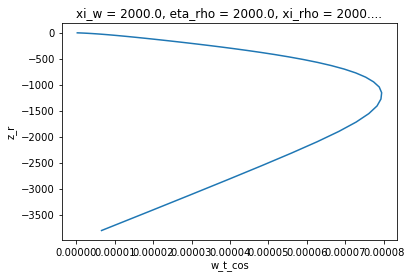

In [63]:
ds = r['his'].isel(x_rho=1, y_rho=1,time=1).persist()
grid = ds.attrs['xgcm-Grid']

z_r = get_z(r, zeta=ds.ssh_a, h=ds.h, vgrid="r", hgrid="r").persist()
z_w = get_z(r, zeta=ds.ssh_a, h=ds.h, vgrid="w", hgrid="r").persist()

w_r = ds.w_t_cos.assign_coords(z_r=z_r).chunk({"s_rho":-1}).persist()
w_r.plot(y="z_r")

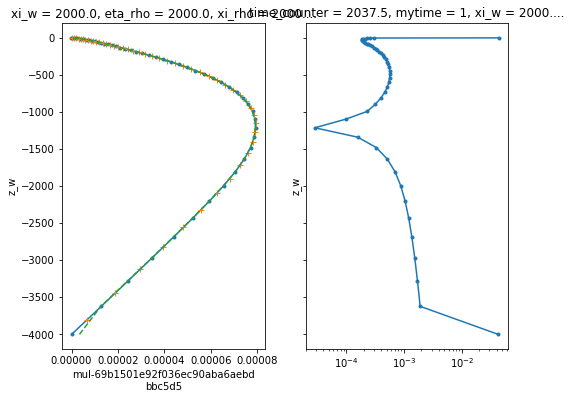

In [64]:
w_w = w_r.swap_dims({"s_rho":"z_r"}).interp(z_r=z_w, kwargs={"fill_value":"extrapolate"})
w_w = w_w.drop("s_rho").drop("z_r").assign_coords(z_w=z_w).persist()
w_g = grid.interp(w_r, "s").assign_coords(z_w=z_w).persist()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8,6))
ax = axs[0]
w_w.plot(y="z_w", marker=".", ax=ax)
w_r.plot(y="z_r", marker="+", linestyle="none", ax=ax)
w_g.plot(y="z_w", linestyle="--", ax=ax)
ax = axs[1]
abs((w_g-w_w)/max(abs(w_r))).plot(ax=ax, y="z_w", xscale="log", marker=".")

In [72]:
abs(w_r).max()

<xarray.DataArray 'w_t_cos' ()>
dask.array<nanmax-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    xi_w          float32 dask.array<chunksize=(), meta=np.ndarray>
    eta_rho       float32 dask.array<chunksize=(), meta=np.ndarray>
    xi_rho        float32 dask.array<chunksize=(), meta=np.ndarray>
    eta_w         float32 dask.array<chunksize=(), meta=np.ndarray>
    time_instant  float64 dask.array<chunksize=(), meta=np.ndarray>
    time_counter  float64 2.038e+03
    f             float32 dask.array<chunksize=(), meta=np.ndarray>
    mytime        int64 1

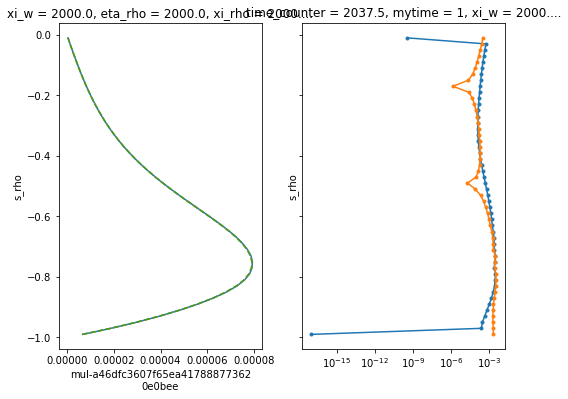

In [76]:
### now working on w2ro

w_rb = w_w.swap_dims({"s_w":"z_w"}).interp(z_w=z_r, kwargs={"fill_value":"extrapolate"}).assign_coords(z_r=z_r)
w_rb = w_rb.drop("z_w").persist()
w_re = grid.interp(w_w, "s").assign_coords(z_r=z_r).persist()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8,6))
ax = axs[0]
w_r.plot(y="s_rho", ax=ax)
w_rb.plot(y="s_rho", linestyle="--", ax=ax)
w_re.plot(y="s_rho", linestyle="--", ax=ax)

ax = axs[1]
(abs(w_rb-w_r)/max(abs(w_r))).plot(y="s_rho", ax=ax, xscale="log", marker=".")
(abs(w_re-w_r)/max(abs(w_r))).plot(y="s_rho", ax=ax, xscale="log", marker=".")


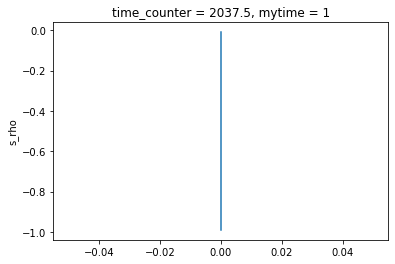

In [94]:
### building my own interpolation: naive one, similar to grid.interp
w1 = .5
w2 = .5
w_i = (w1*w_w.isel(s_w=slice(0,-1)) + w2*w_w.isel(s_w=slice(1,None))).rename({"s_w":"s_rho"})
w_i = w_i.assign_coords(z_r=z_r)

# verify: this shouldbe zero
(w_i-w_re).plot(y="s_rho")

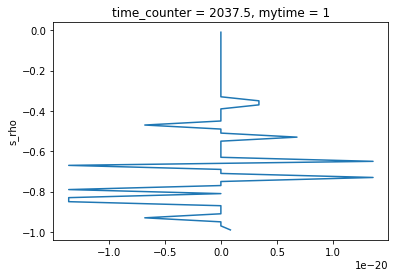

In [105]:
### building my own interpolation: correct one
dzr = grid.diff(z_w, "s") #.diff("s_w")
idn, iup = slice(0,-1), slice(1,None)
rna = {"s_w":"s_rho"}
w1 = (z_w.isel(s_w=iup).rename(rna) - z_r)/dzr
w2 = (z_r - z_w.isel(s_w=idn).rename(rna))/dzr
w_i = (w1*w_w.isel(s_w=idn).rename(rna) + w2*w_w.isel(s_w=iup).rename(rna))
w_i = w_i.assign_coords(z_r=z_r)

# verify: this should be zero
(w_i-w_rb).plot(y="s_rho")

## Wrapper and ND case

In [123]:
def zi_w2rho(data, z_w, z_r):
    """ warning: this version uses grid (xgcm) """
    dzr = grid.diff(z_w, "s") #.diff("s_w")
    idn, iup = slice(0,-1), slice(1,None)
    rna = {"s_w":"s_rho"}
    w1 = (z_w.isel(s_w=iup).rename(rna) - z_r)/dzr
    w2 = (z_r - z_w.isel(s_w=idn).rename(rna))/dzr
    w_i = (w1*data.isel(s_w=idn).rename(rna) + w2*data.isel(s_w=iup).rename(rna))
    return w_i.assign_coords(z_r=z_r)

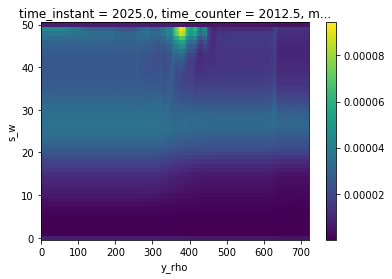

In [125]:
ds = r['his'].isel(time=0).mean("x_rho")

z_r = get_z(r, zeta=ds.ssh_a, h=ds.h, vgrid="r", hgrid="r").persist()
z_w = get_z(r, zeta=ds.ssh_a, h=ds.h, vgrid="w", hgrid="r").persist()

N2 = N2Profile(r,ds.T_a,z_r).chunk({"s_w":-1})
N2 = N2.assign_coords(z_w=z_w).persist()

N2.plot()